### Задание 1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, n_clusters_per_class=1, random_state=5)

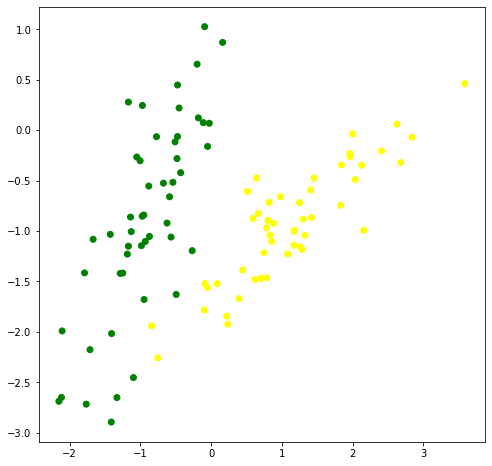

In [4]:
colors = ListedColormap(['green', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], 
                                                                     classification_data)), c=classification_labels, cmap=colors);

In [6]:
def find_best_split(data, labels):
    min_samples_leaf = 5
    root_gini = gini(labels)
    best_gain = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    for index in range(n_features):
        t_values = np.unique(data[:, index])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) > min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            current_gain = gain(true_labels, false_labels, root_gini)
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
    return best_gain, best_t, best_index       
                

In [7]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t # значение порога
        self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

In [8]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        prediction = max(classes, key=classes.get)
        return prediction

In [11]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity    

In [31]:
def gain(left_labels, right_labels, root_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [32]:
def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels

In [33]:
def build_tree(data, labels, tree_depth = 0, max_tree_depth = 7):
    gain, t, index = find_best_split(data, labels)
    if gain == 0:
        return Leaf(data, labels)
    if tree_depth >= max_tree_depth:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    tree_depth += 1
    true_branch = build_tree(true_data, true_labels, tree_depth, max_tree_depth)
    false_branch = build_tree(false_data, false_labels, tree_depth, max_tree_depth)
    return Node(index, t, true_branch, false_branch)

In [34]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)    

In [35]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes    

In [36]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, test_size = 0.3, random_state = 1) 

In [37]:
def print_tree(node, spacing=""):
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [38]:
my_tree = build_tree(train_data, train_labels)
print_tree(my_tree)

Индекс 0 <= -1.4262925430552267
--> True:
  Прогноз: 0
--> False:
  Индекс 0 <= -1.1845330075719176
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0 <= -0.9715037016309751
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.8725985883473684
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0 <= -0.5403007857080191
        --> True:
          Прогноз: 0
        --> False:
          Индекс 0 <= -0.4747745989661639
          --> True:
            Прогноз: 0
          --> False:
            Индекс 0 <= -0.09195833713035761
            --> True:
              Прогноз: 0
            --> False:
              Прогноз: 1


In [39]:
my_tree = build_tree(train_data, train_labels, max_tree_depth=2)
print_tree(my_tree)

Индекс 0 <= -1.4262925430552267
--> True:
  Прогноз: 0
--> False:
  Индекс 0 <= -1.1845330075719176
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 1


###  Задание 2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [40]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels, axis=0)
    
    

def gini(labels):
    return np.var(labels)